# Image Classification with CIFAR10 : Part 2

Part 2 of the project uses the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) in Tensorflow to perform image classification using CIFAR10. You should complete [Part 1](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project3_1.html) first. Part 1 is worth 60% and Part 2 worth 40% of the overall mark.

**Getting Started:** The source files for this project are [here](https://courses.cs.washington.edu/courses/csep576/20sp/projects/project3/project3.zip). To run locally, you will need [IPython/Jupyter](http://jupyter.org/install.html) as well as [Tensorflow](https://www.tensorflow.org/install) installed. Launch Jupyter and open `Project3_2.ipynb`. You can also import this notebook directly into [Colaboratory](https://colab.research.google.com/) without installing anything.

**This project:** You'll start by replicating the linear classifier from [Part 1](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project3_1.html) using the Keras Sequential API. This will give a performance baseline. You'll then work on improved model designs using convolutional layers and tune parameters to get good classification performance.

**What to turn in:** Hand in a zipfile containing your completed .ipynb notebook and any .py files you created. Be sure to describe clearly the results of your investigations.

version `050420`

### Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); 
This is not an official Google product.

In [0]:
#@title 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/CSE576_Project3')
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

!mkdir -p saved_model
!mkdir -p saved_history
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams['font.size'] = 16
# may be needed to avoid mulitply defined openmp libs
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Num GPUs Available:  1


### Download CIFAR10 dataset

We use `keras.datasets` to download the CIFAR10 data, splitting off 1000 images from the training set for validation. The dataset will be cached at `~/.keras/datasets` by default.

170500096/170498071 [==============================] - 13s 0us/step
truck


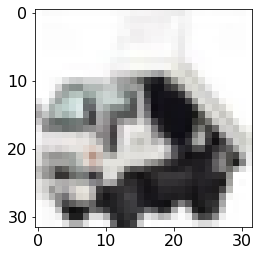

In [3]:
# Load CIFAR10 dataset
(train_images0,train_labels0),(test_images,test_labels) = keras.datasets.cifar10.load_data()

# Normalise images
train_images0=train_images0.astype('float')/255.0
test_images=test_images.astype('float')/255.0

# Create a validation set
num_valid=1000
valid_images=train_images0[0:num_valid]
valid_labels=train_labels0[0:num_valid]
train_images=train_images0[num_valid:]
train_labels=train_labels0[num_valid:]

cifar10_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
num_classes=10
num_train=train_labels.size
num_valid=valid_labels.size
num_test=test_labels.size

# Make one-hot targets
train_one_hot=tf.one_hot(train_labels[:,0],num_classes)
valid_one_hot=tf.one_hot(valid_labels[:,0],num_classes)
test_one_hot=tf.one_hot(test_labels[:,0],num_classes)

# Show a random image and label
rnd=np.random.randint(num_train)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.imshow(train_images[rnd])
print(cifar10_names[train_labels[rnd][0]])

### Define a Linear model using Keras [10%]

We'll start by replicating the linear model from [Part 1](https://courses.cs.washington.edu/courses/csep576/20sp/projects/Project3_1.html). Use the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define a linear model over the input pixels. Complete the code below Hint: try `layers.Flatten` and `layers.Dense`. Check that your layer outputs have the right shape. How many parameters does your model have?

<font color='red'>Answer:</font> My model has 30730 parameters.

In [0]:
# Initialize a Keras sequential model
model=keras.models.Sequential()

"""
*************************************************************
*** TODO: implement a linear model using Keras Sequential API
*************************************************************

The model should compute a single linear function of the input pixels
"""    
# -1 makes numpy compute the dimension
X_train = train_images.reshape(num_train, -1)  
X_valid = valid_images.reshape(num_valid, -1)
input_dim = X_train[0].shape
print('X_train shape: ', X_train.shape)
print('X_valid shape: ', X_valid.shape)
print('Input Dimension: ', input_dim)
output_dim = 10
model.add(layers.Dense(output_dim, input_shape=(input_dim)))

"""
*************************************************************
"""

# output a summary of the model
model.summary()

X_train shape:  (49000, 3072)
X_valid shape:  (1000, 3072)
Input Dimension:  (3072,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


### Train the model

1) Use the code below to train the model with squared-error loss between logits and targets. Try a few different optimizers and loss functions, and running for additional epochs. Which combination works best? 

<font color='red'>Answer:</font> I tried 6 different combinations, the Ada optimizer with mean squared error works the best. All combinations using categorical crossentropy have poor performance.

2) Can you modify the model to implement softmax regression? 

<font color='red'>Answer:</font> 

model.add(layers.Dense(output_dim, input_shape=(input_dim), activation='softmax'))

3) How could you add regularization (L2 penalty) on the weights?

<font color='red'>Answer:</font> 

model.add(layers.Dense(output_dim, input_shape=(input_dim), kernel_regularizer=regularizers.l2(0.001)))


In [0]:
#model.compile(optimizer='sgd', loss='mean_squared_error',metrics=['accuracy'])
#history = model.fit(X_train,train_one_hot,epochs=10,validation_data=(X_valid, valid_one_hot))

"""
******************************************************************
*** TODO: test different training parameters for linear regression
******************************************************************
"""
num_of_model = 6
epochs = 10
models = []
histories = []
optimizers = ['SGD', 'Adam', 'Adagrad', 'SGD', 'Adam', 'Adagrad']
losses = ['mean_squared_error', 'mean_squared_error', 'mean_squared_error', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy']

X_train = train_images.reshape(num_train, -1)  
X_valid = valid_images.reshape(num_valid, -1)
input_dim = X_train[0].shape
output_dim = 10
for i in range(num_of_model):
    models.append(keras.models.Sequential())
    models[i].add(layers.Dense(output_dim, input_shape=(input_dim)))
    models[i].summary()
    models[i].compile(optimizer=optimizers[i], loss=losses[i], metrics=['accuracy'])
    history = models[i].fit(X_train,train_one_hot,epochs=epochs,validation_data=(X_valid, valid_one_hot))
    histories.append(history)
"""
******************************************************************
"""

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1532/1532 [==============================] - 5s 3ms/step - loss: 0.1111 - accuracy: 0.2029 - val_loss: 0.1034 - val_accuracy: 0.2410
Epoch 2/10
1532/1532 [==============================] - 4s 3ms/step - loss: 0.0969 - accuracy: 0.2532 - val_loss: 0.1100 - val_accuracy: 0.2030
Epoch 3/10
1532/1532 [==============================] - 4s 3ms/step - loss: 0.0937 - accuracy: 0.2663 - val_loss: 0.1001 - val_accuracy: 0.2620
Epoch 4/10
1532/1532 [==============================] - 4s 3ms/step - loss: 0.0919 - accuracy: 0.2813 - val_loss: 0.1031 - val_accuracy: 0.2570
Epoch 5/10
1532/1532 [==============================] - 5s 3ms/step 

'\n******************************************************************\n'

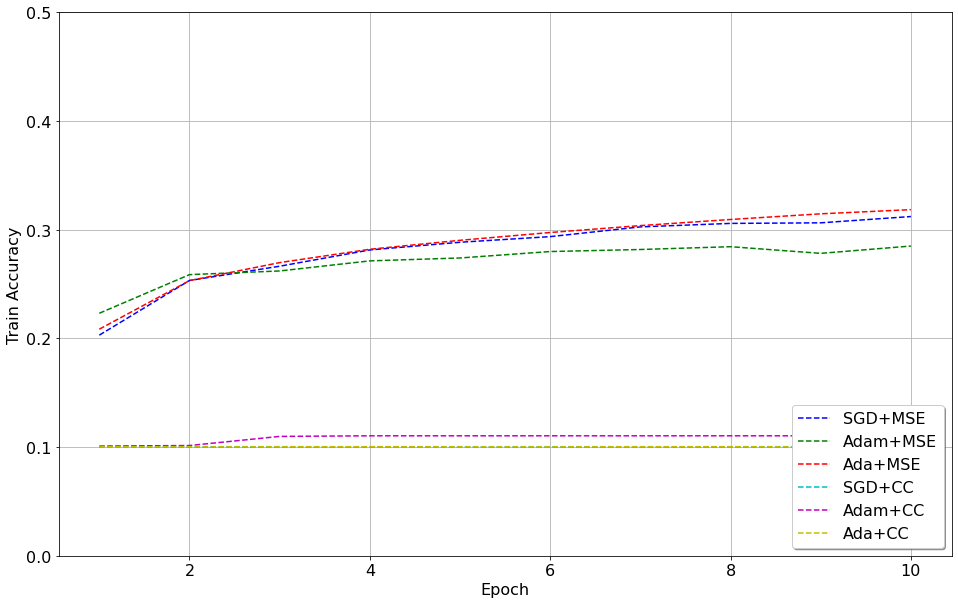

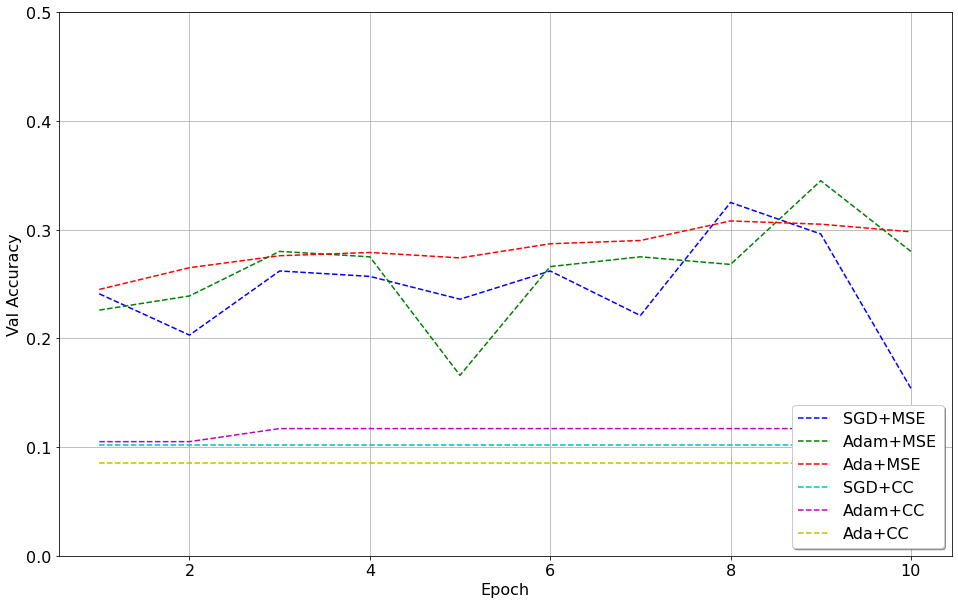

In [0]:
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.rcParams['font.size'] = 16

acc_lines = ['b--', 'g--', 'r--', 'c--', 'm--', 'y--']
acc_label = ['SGD+MSE', 'Adam+MSE', 'Ada+MSE', 'SGD+CC', 'Adam+CC', 'Ada+CC']
yaxis = range(1, epochs+1, 1)

fig=plt.figure()
for i in range(num_of_model):
    history = histories[i]
    plt.plot(yaxis, history.history['accuracy'], acc_lines[i], label=acc_label[i])
plt.grid(True)
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Train Accuracy')
plt.ylim(0,0.5)
plt.xlabel('Epoch')
plt.show()

fig=plt.figure()
for i in range(num_of_model):
    history = histories[i]
    plt.plot(yaxis, history.history['val_accuracy'], acc_lines[i], label=acc_label[i])

plt.grid(True)
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Val Accuracy')
plt.ylim(0,0.5)
plt.xlabel('Epoch')
plt.show()

### Run the model

The following code demonstrates use of `model.predict`. Run the following code to demonstrate running the model on a single input.

predicted = airplane
actual = automobile


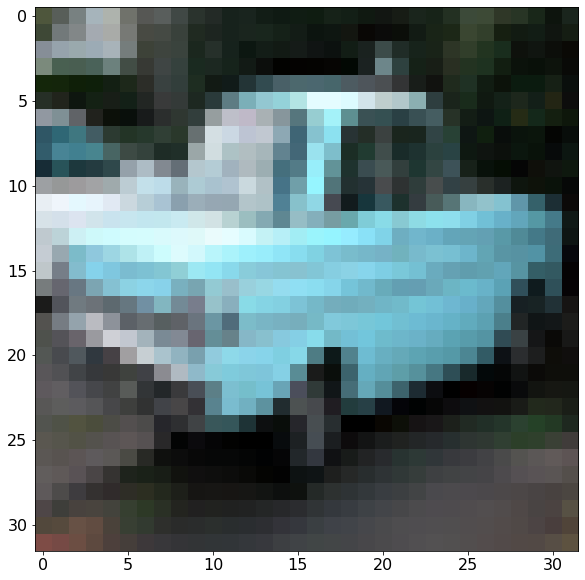

In [0]:
rnd=np.random.randint(num_test)
test_image_rnd=test_images[rnd]
test_label_rnd=test_labels[rnd][0]

X_test = test_image_rnd.reshape(1, -1)

logits=models[0].predict(X_test)
label_pred=np.argmax(logits)
plt.imshow(test_image_rnd)
print('predicted =',cifar10_names[label_pred])
print('actual =',cifar10_names[test_label_rnd])

### Design a new model [5%]

Design your own convolutional net choosing your own set of layers. In the next block, you'll train, tune and visualize outputs from this model.

<font color='red'>Answer:</font> This is the final model i have chosen based on several experiements I have done and I have detail explaination below in the experimental section and Model Evaluation Section.

In [0]:
input_dim = train_images[0].shape
print(input_dim)

finalModel = keras.Sequential()
finalModel.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu",input_shape=input_dim))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
finalModel.add(layers.Dropout(0.4))
finalModel.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
finalModel.add(layers.Dropout(0.5))
finalModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
finalModel.add(layers.Dropout(0.6))
finalModel.add(layers.Flatten())
finalModel.add(layers.Dense(units=1024, activation='relu'))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Dense(units=128, activation='relu'))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Dense(units=10, activation = 'softmax'))
finalModel.summary()

(32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16

### Train, Tune and Visualize the Model [25%]

Train your model and plot training and validation accuracy as a function of time (steps or epochs). Choose some model parameters (e.g., number of layers, filters per layer, kernel size) and study the affect of their settings on performance. Show your findings with plots or tables with validation accuracy as a function of the parameters in your study. Visualize some aspect of your model, e.g., first layer weights, activation distributions. How do they evolve over time?

#### Experimental Sections:
This section only shows the my findings with plots or tables with validation accuracy. If you want to see the training logs, please refer to Appendix A.

<b>1) Experiment with the size of kernal, 11x11, 7x7, 5x5:</b> 

Larger kernal size (11x11) train faster in the beginning, however, after trained for more epoch, the smaller size (5x5) and (7x7) kernal has a better accuracy.

<b>2) Experiment with stacked 3x3 vs 5x5 (Same Receptive field 5x5)</b>

Stacked 3x3 kernal size and 5x5 kernal size both have the same receptive field. The stacked 3x3 kernal size has a better performace than 5x5 kernal, which has a better accuracy and less time to train.

<b>3) Experiement with different numbers of filters (channels):</b>

When number of filters (channels) increased in a layer, the number of parameters are increased, it also improved the accuracy of the model.

<b>4) Experiement with deeper model vs wider model:</b>

Deeper model (more layers with small kernal size) requires more time to train compare to wider model (less layers with big kernal size). However, Deeper model have more accuracy when trained for more epochs.

<b>5) Experiment with different optimizers / loss functions:</b>

Among these 6 different combination of optimizers and loss function. The Adam optimizer with Categorical Crossentropy provides the best validation accuracy for me.

Text(0.5, 0, 'Epoch')

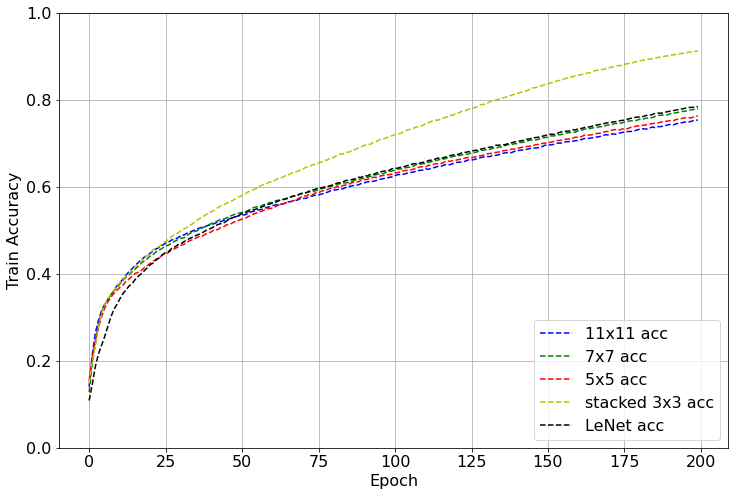

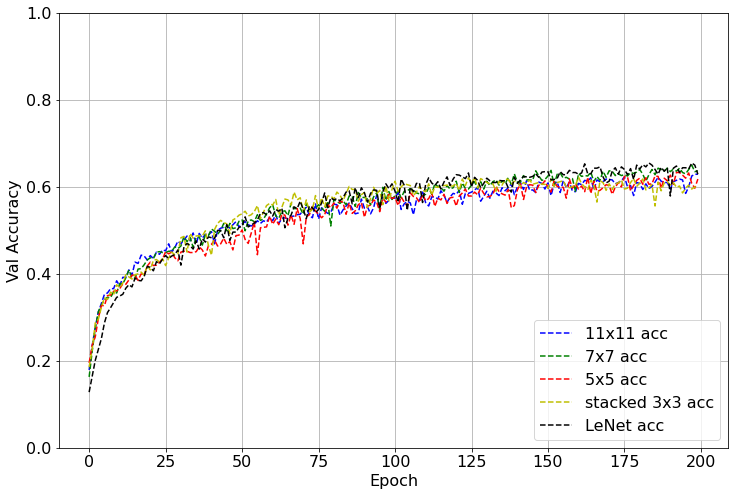

In [0]:
h_11x11 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_11x11.csv").to_dict()
h_7x7 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_7x7.csv").to_dict()
h_5x5 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_5x5.csv").to_dict()
h_s3x3 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_stacked_3x3.csv").to_dict()
h_LeNet = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_LeNet.csv").to_dict()

plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 16

lines = ['b--', 'g--', 'r--', 'y--', 'k--']
label = ['11x11 acc', '7x7 acc', '5x5 acc', 'stacked 3x3 acc', 'LeNet acc']
histories = [h_11x11, h_7x7, h_5x5, h_s3x3, h_LeNet]

fig=plt.figure()
for i in range(len(histories)):
    history = histories[i]
    length = range(0, len(history['accuracy']), 1)
    accuracy = []
    val_accuracy = []
    for j in length:
      accuracy.append(history['accuracy'][j])
    plt.plot(length, accuracy, lines[i], label=label[i])

plt.grid(True)
plt.legend(loc='lower right')
plt.ylabel('Train Accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')

fig=plt.figure()
for i in range(len(histories)):
    history = histories[i]
    length = range(0, len(history['accuracy']), 1)
    accuracy = []
    val_accuracy = []
    for j in length:
      val_accuracy.append(history['val_accuracy'][j])
    plt.plot(length, val_accuracy, lines[i], label=label[i])

plt.grid(True)
plt.legend(loc='lower right')
plt.ylabel('Val Accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')

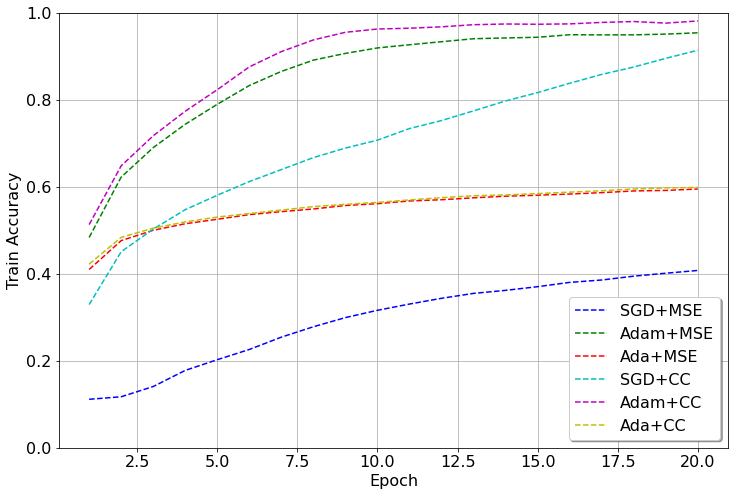

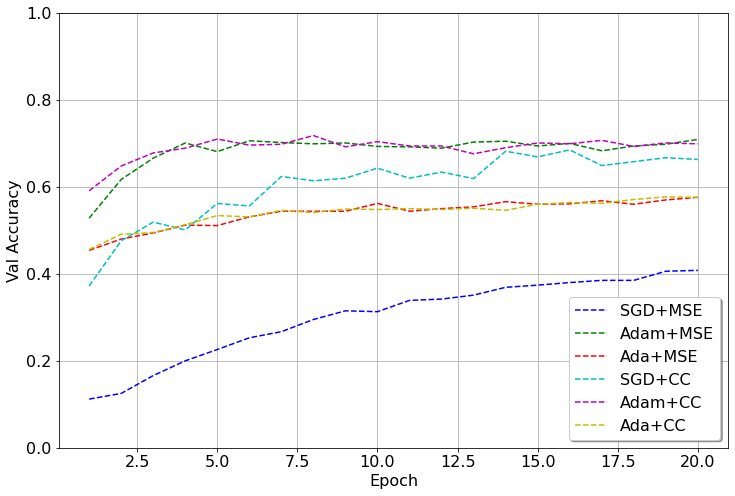

In [0]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 16

lines = ['b--', 'g--', 'r--', 'c--', 'm--', 'y--']
label = ['SGD+MSE', 'Adam+MSE', 'Ada+MSE', 'SGD+CC', 'Adam+CC', 'Ada+CC']
yaxis = range(1, epochs+1, 1)

fig=plt.figure()
for i in range(num_of_model):
    history = histories[i]
    plt.plot(yaxis, history.history['accuracy'], lines[i], label=label[i])
plt.grid(True)
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Train Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.show()

fig=plt.figure()
for i in range(num_of_model):
    history = histories[i]
    plt.plot(yaxis, history.history['val_accuracy'], lines[i], label=label[i])

plt.grid(True)
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Val Accuracy')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.show()

#### Evaluate the model:
This section only shows the my findings with plots or tables with validation accuracy. If you want to see the training logs, please refer to Appendix B.

<b>Model 1: </b> 

I used the expermiental sections finding and the simplied LeNet model as my baseline. However, instead of using a only 1 convulution layer before the subsampling (thats what LeNet does), I used the Stacked 3x3 Convolution layers (which has a 5x5 Receptive Field) before the Maxpooling (subsampling). Finally, Flatten and Softmax to 10 outputs. This model has a val accuracy of 68.70%.

<b>Model 2: </b> 

Taking from the experience in Model 1, I decided to add more layers into model 1. The reason of adding more layers has been explained in the experimental section, where deeper networks work better than wider network. I added another stacked 3x3 Convolution layers (which has a 5x5 Receptive Field) and a triplet 3x3 Concolution layers (which has a 7x7 Receptive Field). This model has a val accuracy of 73.20%.

<b>Model 3: </b> 

Again, I added another triplet 3x3 Concolution layers (which has a 7x7 Receptive Field) tried to improve the val accuracy. However, this model is now harder to train and does not have much improvement. Instead of keep adding more layers, I used other parameters in below model. This model has a val accuracy of 72.00%.

<b>Model 4: </b> 

Instead of keep adding more layers, I have dropped the model 3 and made improvements to model 2 due to model 2 has similar accuracy and train faster. I have added Batch Normalization to increase the stability of a neural network. However, the model now have a overfitting problem, where the training accuracy is close to 95% but the validation accuracy does not continue to improve. This model has a val accuracy of 81.90%.

<b>Final Model: </b> 

To overcome the overfitting problem, I added dropout layer for regularisation after each subsampling layer. I have added more filters for each convolution layers. I also trained longer to see if the validation accuracy can improve. This model has a val accuracy of 88.10% with 20 epoches. It can achieve a val accuracy = 88.30 % at 50 epoches.

<b>Final Model Test Loss/Accuracy: </b> 

Test loss: 0.5871

Test accuracy: 87.07%

<b>Summary of all models: </b> 
<table align="left" style="border: 1px solid black;align="left"">
  <tr style="border: 1px solid black;">
    <th style="border: 1px solid black; text-align: center;">Model</th>
    <th style="border: 1px solid black; text-align: center;">Epoch</th>
    <th style="border: 1px solid black; text-align: center;">Val Accuracy</th>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black;">Model 1</td>
    <td style="border: 1px solid black;">20</td>
    <td style="border: 1px solid black;">68.70%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black;">Model 2</td>
    <td style="border: 1px solid black;">20</td>
    <td style="border: 1px solid black;">73.20%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black;">Model 3</td>
    <td style="border: 1px solid black;">20</td>
    <td style="border: 1px solid black;">72.00%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black;">Model 4</td>
    <td style="border: 1px solid black;">20</td>
    <td style="border: 1px solid black;">81.90%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black;">Final Model</td>
    <td style="border: 1px solid black;">20</td>
    <td style="border: 1px solid black;">88.10%</td>
  </tr>
  <tr style="border: 1px solid black;">
    <td style="border: 1px solid black;">Final Model</td>
    <td style="border: 1px solid black;">50</td>
    <td style="border: 1px solid black;">88.30%</td>
  </tr>
</table>

313/313 - 1s - loss: 0.5871 - accuracy: 0.8707


Text(0.5, 0, 'Epoch')

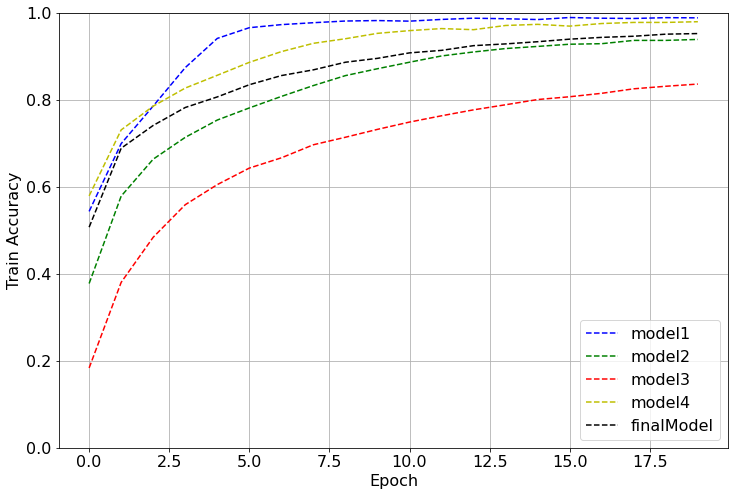

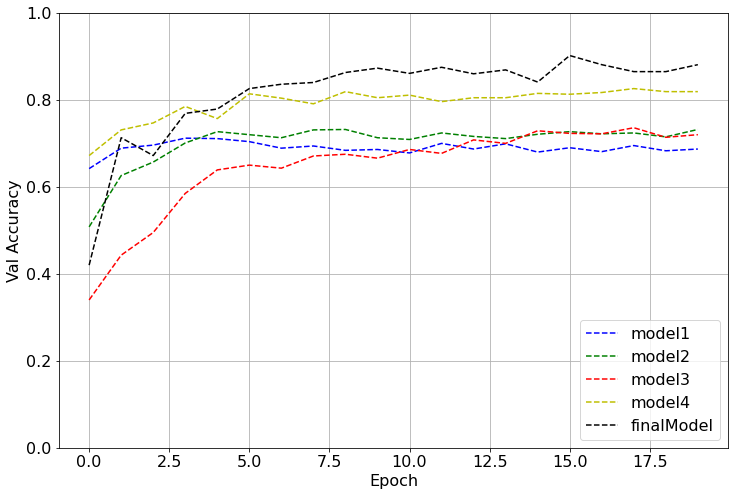

In [6]:
model1 = tf.keras.models.load_model("/content/gdrive/My Drive/CSE576_Project3/saved_model/model1")
model2 = tf.keras.models.load_model("/content/gdrive/My Drive/CSE576_Project3/saved_model/model2")
model3 = tf.keras.models.load_model("/content/gdrive/My Drive/CSE576_Project3/saved_model/model3")
model4 = tf.keras.models.load_model("/content/gdrive/My Drive/CSE576_Project3/saved_model/model4")
finalModel = tf.keras.models.load_model("/content/gdrive/My Drive/CSE576_Project3/saved_model/finalModel")
finalModelM = tf.keras.models.load_model("/content/gdrive/My Drive/CSE576_Project3/saved_model/finalModel_more")

hmodel1 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model1.csv").to_dict()
hmodel2 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model2.csv").to_dict()
hmodel3 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model3.csv").to_dict()
hmodel4 = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model4.csv").to_dict()
hfinalModel = pd.read_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/finalModel.csv").to_dict()

# Compute the final model test loss and accuracy
test_loss, test_acc = finalModelM.evaluate(test_images,test_one_hot,verbose=2)

plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['font.size'] = 16

lines = ['b--', 'g--', 'r--', 'y--', 'k--']
label = ['model1', 'model2', 'model3', 'model4', 'finalModel']
histories = [hmodel1, hmodel2, hmodel3, hmodel4, hfinalModel]

fig=plt.figure()
for i in range(len(histories)):
    history = histories[i]
    length = range(0, len(history['accuracy']), 1)
    accuracy = []
    val_accuracy = []
    for j in length:
      accuracy.append(history['accuracy'][j])
    plt.plot(length, accuracy, lines[i], label=label[i])

plt.grid(True)
plt.legend(loc='lower right')
plt.ylabel('Train Accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')

fig=plt.figure()
for i in range(len(histories)):
    history = histories[i]
    length = range(0, len(history['accuracy']), 1)
    accuracy = []
    val_accuracy = []
    for j in length:
      val_accuracy.append(history['val_accuracy'][j])
    plt.plot(length, val_accuracy, lines[i], label=label[i])

plt.grid(True)
plt.legend(loc='lower right')
plt.ylabel('Val Accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')

#### Weights/Filters Visualization

<b>Visualizations: </b> 

1) Show the weight of first stacked 3x3 layers

2) Show the image and the corresponding 16 output after the first stacked 3x3 layers

3) Show the image and the corresponding 16 output in the last triplet 3x3 layers

<b>Observations: </b> 

1) As I can see the results from the first stacked 3x3 filters are doing feature extractions like edge dectetor, color filtering, corner detection, etc. The later filters are doing fine details extraction. This observations make me decided to have more filters (channels) for the later layers back into my model since there are many different types of fine details in the image.

2) Some filters produce zero's output in the images (i.e. if you look at some of the output of the first layer, the whole output is black). I believe those filters are doing feature extration for specific class. Some classes will provide non-zero output, some class will produce zero's output

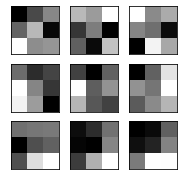

In [0]:
# Weight of the first layer filters

# get first layers filters
filters, biases = finalModel.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

fig = plt.figure(figsize=(3, 3))

# plot first 9 filters
n_filters, ix = 3, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1

# show the figure
plt.show()

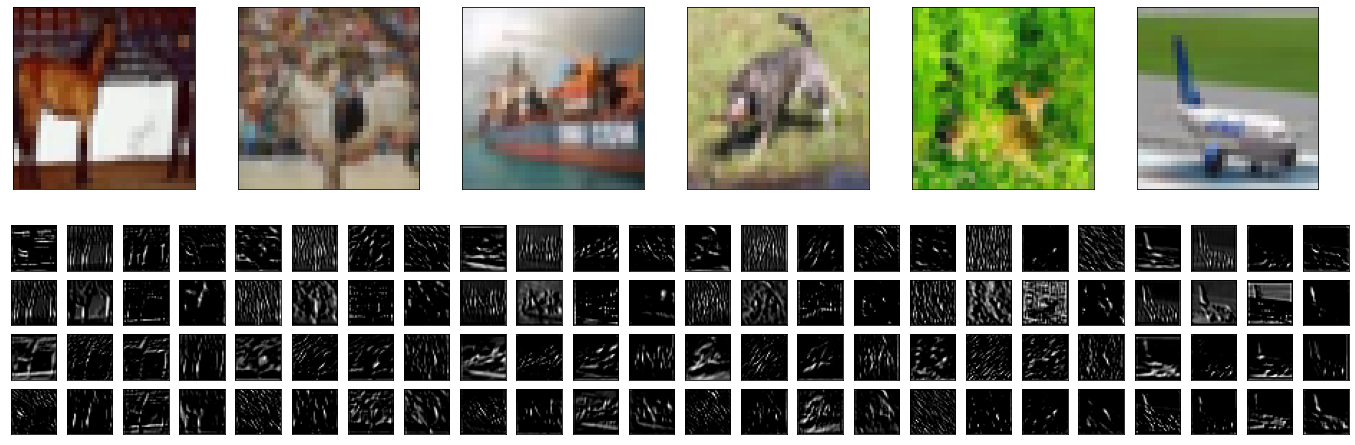

In [0]:
# Show the image and the corresponding 16 output after the first stacked 3x3 layers

from tensorflow.keras.models import Model
vmodel = Model(inputs=finalModel.inputs, outputs=finalModel.layers[2].output)

# num of samples
num = 6

# show the figure
fig = plt.figure(figsize=(4.0*num, 8.0*num))
grid = plt.GridSpec(16*num, 8*num, wspace=0.5, hspace=0.5)

for i in range(num):
	# Get an random image with the required shape
	rnd=np.random.randint(num_test)
	rnd_image=train_images[rnd]
	rnd_image=np.expand_dims(rnd_image, axis=0)

	# get feature map for first hidden layer
	feature_maps = vmodel.predict(rnd_image)
 
	s = i * 8
	im_in = fig.add_subplot(grid[0:7, 0+s:7+s])
	im_in.set_xticks([])
	im_in.set_yticks([])
	im_in.imshow(train_images[rnd])

	ix = 1
	for y in range(8,16,2):
		for x in range(0+s,7+s,2):
			# specify subplot and turn of axis
			im_out = plt.subplot(grid[y:y+2,x:x+2])
			im_out.set_xticks([])
			im_out.set_yticks([])
			# plot filter channel in grayscale
			im_out.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
			ix += 1

plt.show()

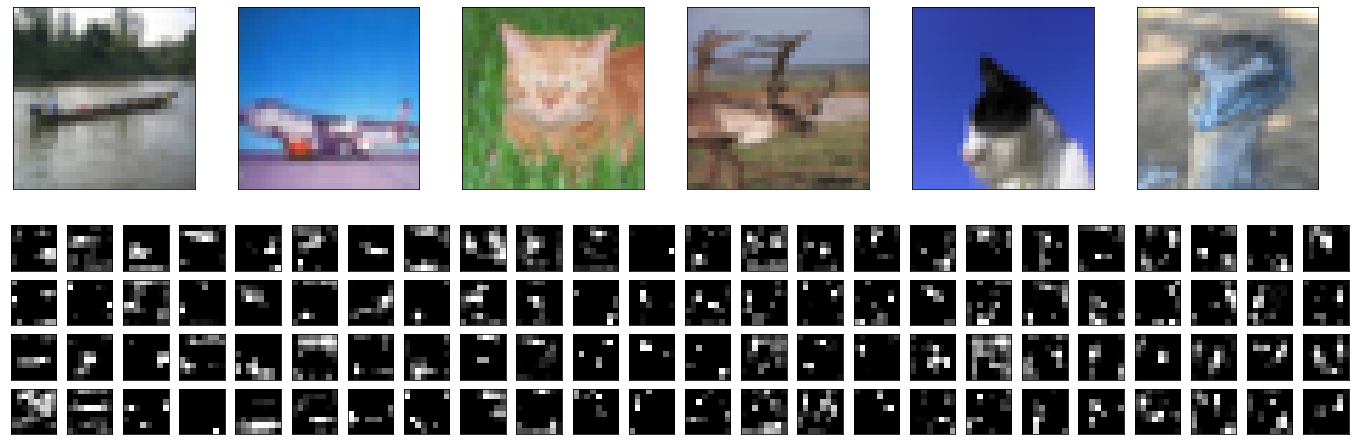

In [0]:
from tensorflow.keras.models import Model
vmodel = Model(inputs=finalModel.inputs, outputs=finalModel.layers[17].output)

# num of samples
num = 6

# show the figure
fig = plt.figure(figsize=(4.0*num, 8.0*num))
grid = plt.GridSpec(16*num, 8*num, wspace=0.5, hspace=0.5)

for i in range(num):
	# Get an random image with the required shape
	rnd=np.random.randint(num_test)
	rnd_image=train_images[rnd]
	rnd_image=np.expand_dims(rnd_image, axis=0)

	# get feature map for first hidden layer
	feature_maps = vmodel.predict(rnd_image)
 
	s = i * 8
	im_in = fig.add_subplot(grid[0:7, 0+s:7+s])
	im_in.set_xticks([])
	im_in.set_yticks([])
	im_in.imshow(train_images[rnd])

	ix = 1
	for y in range(8,16,2):
		for x in range(0+s,7+s,2):
			# specify subplot and turn of axis
			im_out = plt.subplot(grid[y:y+2,x:x+2])
			im_out.set_xticks([])
			im_out.set_yticks([])
			# plot filter channel in grayscale
			im_out.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
			ix += 1

plt.show()

#### Appendix A
It contains the training logs for experimental sections


In [0]:
input_dim = train_images[0].shape
print(input_dim)
model_11x11 = keras.Sequential()
model_11x11.add(layers.Conv2D(filters=20, kernel_size=(11, 11), activation='relu', input_shape=input_dim))
model_11x11.add(layers.MaxPooling2D())
model_11x11.add(layers.Flatten())
model_11x11.add(layers.Dense(units=500, activation='relu'))
model_11x11.add(layers.Dense(units=10, activation = 'softmax'))
model_11x11.summary()

(32, 32, 3)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 20)        7280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2420)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               1210500   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5010      
Total params: 1,222,790
Trainable params: 1,222,790
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_11x11.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
history_11x11 = model_11x11.fit(train_images, train_one_hot, epochs=200, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history_11x11.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_11x11.csv")
model_11x11.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model_11x11')

Epoch 1/200
1532/1532 [==============================] - 5s 4ms/step - loss: 0.0895 - accuracy: 0.1408 - val_loss: 0.0887 - val_accuracy: 0.1790
Epoch 2/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0877 - accuracy: 0.2123 - val_loss: 0.0861 - val_accuracy: 0.2350
Epoch 3/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0850 - accuracy: 0.2635 - val_loss: 0.0833 - val_accuracy: 0.2770
Epoch 4/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0829 - accuracy: 0.2915 - val_loss: 0.0813 - val_accuracy: 0.3120
Epoch 5/200
1532/1532 [==============================] - 5s 4ms/step - loss: 0.0815 - accuracy: 0.3138 - val_loss: 0.0802 - val_accuracy: 0.3320
Epoch 6/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0805 - accuracy: 0.3286 - val_loss: 0.0789 - val_accuracy: 0.3530
Epoch 7/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0795 - accuracy: 0.3400 - val_loss: 0.0781 - val_ac

In [0]:
input_dim = train_images[0].shape
print(input_dim)
model_7x7 = keras.Sequential()
model_7x7.add(layers.Conv2D(filters=20, kernel_size=(7, 7), activation='relu', input_shape=input_dim))
model_7x7.add(layers.MaxPooling2D())
model_7x7.add(layers.Flatten())
model_7x7.add(layers.Dense(units=500, activation='relu'))
model_7x7.add(layers.Dense(units=10, activation = 'softmax'))
model.summary()

(32, 32, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_7x7.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
history_7x7 = model_7x7.fit(train_images, train_one_hot, epochs=200, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history_7x7.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_7x7.csv")
model_7x7.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model_7x7')

Epoch 1/200
1532/1532 [==============================] - 5s 4ms/step - loss: 0.0893 - accuracy: 0.1284 - val_loss: 0.0884 - val_accuracy: 0.1630
Epoch 2/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0875 - accuracy: 0.1904 - val_loss: 0.0861 - val_accuracy: 0.2220
Epoch 3/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0852 - accuracy: 0.2404 - val_loss: 0.0835 - val_accuracy: 0.2740
Epoch 4/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0832 - accuracy: 0.2825 - val_loss: 0.0815 - val_accuracy: 0.3130
Epoch 5/200
1532/1532 [==============================] - 5s 3ms/step - loss: 0.0817 - accuracy: 0.3111 - val_loss: 0.0801 - val_accuracy: 0.3280
Epoch 6/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0806 - accuracy: 0.3279 - val_loss: 0.0790 - val_accuracy: 0.3410
Epoch 7/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0796 - accuracy: 0.3403 - val_loss: 0.0783 - val_ac

In [0]:
input_dim = train_images[0].shape
print(input_dim)

model_5x5 = keras.Sequential()
model_5x5.add(layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=input_dim))
model_5x5.add(layers.MaxPooling2D())
model_5x5.add(layers.Flatten())
model_5x5.add(layers.Dense(units=500, activation='relu'))
model_5x5.add(layers.Dense(units=10, activation = 'softmax'))
model.summary()

(32, 32, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_5x5.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
history_5x5 = model_5x5.fit(train_images, train_one_hot, epochs=200, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history_5x5.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_5x5.csv")
model_5x5.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model_5x5')

Epoch 1/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0894 - accuracy: 0.1545 - val_loss: 0.0884 - val_accuracy: 0.1950
Epoch 2/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0876 - accuracy: 0.2092 - val_loss: 0.0864 - val_accuracy: 0.2360
Epoch 3/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0856 - accuracy: 0.2460 - val_loss: 0.0841 - val_accuracy: 0.2550
Epoch 4/200
1532/1532 [==============================] - 5s 4ms/step - loss: 0.0837 - accuracy: 0.2748 - val_loss: 0.0822 - val_accuracy: 0.2970
Epoch 5/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0822 - accuracy: 0.2998 - val_loss: 0.0807 - val_accuracy: 0.3270
Epoch 6/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0810 - accuracy: 0.3196 - val_loss: 0.0797 - val_accuracy: 0.3270
Epoch 7/200
1532/1532 [==============================] - 6s 4ms/step - loss: 0.0801 - accuracy: 0.3339 - val_loss: 0.0787 - val_ac

In [0]:
input_dim = train_images[0].shape
print(input_dim)

model_stacked_3x3 = keras.Sequential()
model_stacked_3x3.add(layers.Conv2D(filters=20, kernel_size=(3, 3), input_shape=input_dim))
model_stacked_3x3.add(layers.Conv2D(filters=20, kernel_size=(3, 3), activation='relu', input_shape=input_dim))
model_stacked_3x3.add(layers.MaxPooling2D())
model_stacked_3x3.add(layers.Flatten())
model_stacked_3x3.add(layers.Dense(units=500, activation='relu'))
model_stacked_3x3.add(layers.Dense(units=10, activation = 'softmax'))
model_stacked_3x3.summary()

(32, 32, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 20)        560       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 20)        3620      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1960500   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5010      
Total params: 1,969,690
Trainable params: 1,969,690
Non-trainable params: 0
________________________________

In [0]:
model_stacked_3x3.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
history_stacked_3x3 = model_stacked_3x3.fit(train_images, train_one_hot, epochs=200, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history_stacked_3x3.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_stacked_3x3.csv")
model_stacked_3x3.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model_stacked_3x3')

Epoch 1/200
1532/1532 [==============================] - 96s 63ms/step - loss: 0.0893 - accuracy: 0.1480 - val_loss: 0.0886 - val_accuracy: 0.1860
Epoch 2/200
1532/1532 [==============================] - 96s 63ms/step - loss: 0.0879 - accuracy: 0.1953 - val_loss: 0.0868 - val_accuracy: 0.2260
Epoch 3/200
1532/1532 [==============================] - 96s 63ms/step - loss: 0.0861 - accuracy: 0.2332 - val_loss: 0.0846 - val_accuracy: 0.2870
Epoch 4/200
1532/1532 [==============================] - 96s 63ms/step - loss: 0.0841 - accuracy: 0.2740 - val_loss: 0.0825 - val_accuracy: 0.2950
Epoch 5/200
1532/1532 [==============================] - 97s 63ms/step - loss: 0.0822 - accuracy: 0.3057 - val_loss: 0.0805 - val_accuracy: 0.3230
Epoch 6/200
1532/1532 [==============================] - 97s 63ms/step - loss: 0.0807 - accuracy: 0.3276 - val_loss: 0.0792 - val_accuracy: 0.3450
Epoch 7/200
1532/1532 [==============================] - 103s 67ms/step - loss: 0.0796 - accuracy: 0.3401 - val_loss: 

In [0]:
input_dim = train_images[0].shape
print(input_dim)

model_LeNet = keras.Sequential()
model_LeNet.add(layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=input_dim))
model_LeNet.add(layers.MaxPooling2D())
model_LeNet.add(layers.Conv2D(filters=50, kernel_size=(3, 3), padding='same', activation='relu'))
model_LeNet.add(layers.MaxPooling2D())
model_LeNet.add(layers.Flatten())
model_LeNet.add(layers.Dense(units=500, activation='relu'))
model_LeNet.add(layers.Dense(units=10, activation = 'softmax'))
model_LeNet.summary()

(32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        9050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_2 (Dense)              (None, 10)   

In [0]:
model_LeNet.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
history_LeNet = model_LeNet.fit(train_images, train_one_hot, epochs=200, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history_LeNet.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model_LeNet.csv")
model_LeNet.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model_LeNet')

In [0]:
num_of_model = 6
epochs = 20
models = []
histories = []
optimizers = ['SGD', 'Adam', 'Adagrad', 'SGD', 'Adam', 'Adagrad']
losses = ['mean_squared_error', 'mean_squared_error', 'mean_squared_error', 'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy']

X_train = train_images.reshape(num_train, -1)  
X_valid = valid_images.reshape(num_valid, -1)
input_dim = X_train[0].shape
output_dim = 10
for i in range(num_of_model):
    models.append(keras.models.clone_model(model_LeNet))
    models[i].summary()
    models[i].compile(optimizer=optimizers[i], loss=losses[i], metrics=['accuracy'])
    history = models[i].fit(train_images,train_one_hot,epochs=epochs,validation_data=(valid_images, valid_one_hot))
    histories.append(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        9050      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1225500   
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

#### Appendix B
It contains the training logs for evaluate the model sections


In [0]:
input_dim = train_images[0].shape
print(input_dim)

model1 = keras.Sequential()
model1.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu",input_shape=input_dim))
model1.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model1.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=1024, activation='relu'))
model1.add(layers.Dense(units=10, activation = 'softmax'))
model1.summary()

(32, 32, 3)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dense_32 (Dense)             (None, 10)                10250     
Total params: 8,410,026
Trainable params: 8,410,026
Non-trainable params: 0
_______________________________

In [0]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_images, train_one_hot, epochs=20, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history1.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model1.csv")
model1.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model1')

Epoch 1/20
1532/1532 [==============================] - 8s 5ms/step - loss: 1.2726 - accuracy: 0.5437 - val_loss: 1.0216 - val_accuracy: 0.6420
Epoch 2/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.8555 - accuracy: 0.6995 - val_loss: 0.8872 - val_accuracy: 0.6890
Epoch 3/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.6079 - accuracy: 0.7859 - val_loss: 0.8966 - val_accuracy: 0.6960
Epoch 4/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.3632 - accuracy: 0.8742 - val_loss: 0.9706 - val_accuracy: 0.7120
Epoch 5/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.1753 - accuracy: 0.9414 - val_loss: 1.2770 - val_accuracy: 0.7110
Epoch 6/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.1009 - accuracy: 0.9660 - val_loss: 1.6042 - val_accuracy: 0.7040
Epoch 7/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.0787 - accuracy: 0.9731 - val_loss: 1.8286 - val_accuracy:

In [0]:
input_dim = train_images[0].shape
print(input_dim)

model2 = keras.Sequential()
model2.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu",input_shape=input_dim))
model2.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(units=256, activation='relu'))
model2.add(layers.Dense(units=10, activation = 'softmax'))
model2.summary()

(32, 32, 3)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 8, 8,

In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_images, train_one_hot, epochs=20, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history2.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model2.csv")
model2.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model2')

Epoch 1/20
1532/1532 [==============================] - 8s 5ms/step - loss: 1.6774 - accuracy: 0.3778 - val_loss: 1.3649 - val_accuracy: 0.5080
Epoch 2/20
1532/1532 [==============================] - 8s 5ms/step - loss: 1.1666 - accuracy: 0.5788 - val_loss: 1.0012 - val_accuracy: 0.6260
Epoch 3/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.9516 - accuracy: 0.6638 - val_loss: 0.9403 - val_accuracy: 0.6570
Epoch 4/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.8107 - accuracy: 0.7139 - val_loss: 0.8859 - val_accuracy: 0.7010
Epoch 5/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.7020 - accuracy: 0.7537 - val_loss: 0.7641 - val_accuracy: 0.7270
Epoch 6/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.6187 - accuracy: 0.7815 - val_loss: 0.7797 - val_accuracy: 0.7200
Epoch 7/20
1532/1532 [==============================] - 8s 5ms/step - loss: 0.5433 - accuracy: 0.8080 - val_loss: 0.8321 - val_accuracy:

In [0]:
input_dim = train_images[0].shape
print(input_dim)

model3 = keras.Sequential()
model3.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu",input_shape=input_dim))
model3.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(units=128, activation='relu'))
model3.add(layers.Dense(units=10, activation = 'softmax'))
model3.summary()

(32, 32, 3)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 8, 8,

In [0]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train_images, train_one_hot, epochs=20, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history3.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model3.csv")
model3.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model3')

Epoch 1/20
1532/1532 [==============================] - 12s 8ms/step - loss: 2.1025 - accuracy: 0.1837 - val_loss: 1.6830 - val_accuracy: 0.3400
Epoch 2/20
1532/1532 [==============================] - 11s 7ms/step - loss: 1.6134 - accuracy: 0.3805 - val_loss: 1.4700 - val_accuracy: 0.4430
Epoch 3/20
1532/1532 [==============================] - 11s 7ms/step - loss: 1.3949 - accuracy: 0.4842 - val_loss: 1.3815 - val_accuracy: 0.4950
Epoch 4/20
1532/1532 [==============================] - 11s 7ms/step - loss: 1.2175 - accuracy: 0.5590 - val_loss: 1.1551 - val_accuracy: 0.5850
Epoch 5/20
1532/1532 [==============================] - 11s 7ms/step - loss: 1.0985 - accuracy: 0.6052 - val_loss: 1.0663 - val_accuracy: 0.6390
Epoch 6/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.9980 - accuracy: 0.6432 - val_loss: 1.0198 - val_accuracy: 0.6500
Epoch 7/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.9332 - accuracy: 0.6668 - val_loss: 1.0840 - val_ac

In [0]:
input_dim = train_images[0].shape
print(input_dim)

model4 = keras.Sequential()
model4.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu",input_shape=input_dim))
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model4.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model4.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(units=256, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(units=10, activation = 'softmax'))
model4.summary()

(32, 32, 3)
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_73 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_75 (Batc (None, 16, 1

In [0]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(train_images, train_one_hot, epochs=20, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(history4.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/model4.csv")
model4.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/model4')

Epoch 1/20
1532/1532 [==============================] - 10s 7ms/step - loss: 1.1986 - accuracy: 0.5793 - val_loss: 0.9469 - val_accuracy: 0.6720
Epoch 2/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.7765 - accuracy: 0.7310 - val_loss: 0.7563 - val_accuracy: 0.7310
Epoch 3/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.6198 - accuracy: 0.7857 - val_loss: 0.7614 - val_accuracy: 0.7470
Epoch 4/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.4997 - accuracy: 0.8272 - val_loss: 0.6247 - val_accuracy: 0.7850
Epoch 5/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.4138 - accuracy: 0.8566 - val_loss: 0.7446 - val_accuracy: 0.7570
Epoch 6/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.3245 - accuracy: 0.8863 - val_loss: 0.5461 - val_accuracy: 0.8140
Epoch 7/20
1532/1532 [==============================] - 10s 7ms/step - loss: 0.2552 - accuracy: 0.9110 - val_loss: 0.5987 - val_ac

In [0]:
input_dim = train_images[0].shape
print(input_dim)

finalModel = keras.Sequential()
finalModel.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu",input_shape=input_dim))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
finalModel.add(layers.Dropout(0.3))
finalModel.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
finalModel.add(layers.Dropout(0.4))
finalModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
finalModel.add(layers.Dropout(0.5))
finalModel.add(layers.Flatten())
finalModel.add(layers.Dense(units=512, activation='relu'))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Dense(units=128, activation='relu'))
finalModel.add(layers.BatchNormalization())
finalModel.add(layers.Dense(units=10, activation = 'softmax'))
finalModel.summary()

(32, 32, 3)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_155 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_156 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 16, 1

In [0]:
finalModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historyf = finalModel.fit(train_images, train_one_hot, epochs=20, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(historyf.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/finalModel.csv")
finalModel.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/finalModel')

Epoch 1/20
1532/1532 [==============================] - 19s 13ms/step - loss: 1.3717 - accuracy: 0.5073 - val_loss: 1.8031 - val_accuracy: 0.4200
Epoch 2/20
1532/1532 [==============================] - 19s 12ms/step - loss: 0.8959 - accuracy: 0.6889 - val_loss: 0.8229 - val_accuracy: 0.7130
Epoch 3/20
1532/1532 [==============================] - 19s 12ms/step - loss: 0.7448 - accuracy: 0.7413 - val_loss: 0.9186 - val_accuracy: 0.6720
Epoch 4/20
1532/1532 [==============================] - 19s 12ms/step - loss: 0.6339 - accuracy: 0.7825 - val_loss: 0.6634 - val_accuracy: 0.7690
Epoch 5/20
1532/1532 [==============================] - 19s 12ms/step - loss: 0.5496 - accuracy: 0.8069 - val_loss: 0.6008 - val_accuracy: 0.7790
Epoch 6/20
1532/1532 [==============================] - 19s 12ms/step - loss: 0.4763 - accuracy: 0.8349 - val_loss: 0.5149 - val_accuracy: 0.8260
Epoch 7/20
1532/1532 [==============================] - 19s 12ms/step - loss: 0.4186 - accuracy: 0.8559 - val_loss: 0.4819 -

In [0]:
finalModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historyfm = finalModel.fit(train_images, train_one_hot, epochs=30, validation_data=(valid_images, valid_one_hot))
pd.DataFrame(historyfm.history).to_csv("/content/gdrive/My Drive/CSE576_Project3/saved_history/finalModel_more.csv")
finalModel.save('/content/gdrive/My Drive/CSE576_Project3/saved_model/finalModel_more')

Epoch 1/30
1532/1532 [==============================] - 19s 12ms/step - loss: 0.1340 - accuracy: 0.9527 - val_loss: 0.4215 - val_accuracy: 0.8790
Epoch 2/30
1532/1532 [==============================] - 19s 12ms/step - loss: 0.1194 - accuracy: 0.9592 - val_loss: 0.4285 - val_accuracy: 0.8820
Epoch 3/30
1532/1532 [==============================] - 19s 12ms/step - loss: 0.1153 - accuracy: 0.9597 - val_loss: 0.4278 - val_accuracy: 0.8880
Epoch 4/30
1532/1532 [==============================] - 19s 12ms/step - loss: 0.1096 - accuracy: 0.9615 - val_loss: 0.5284 - val_accuracy: 0.8660
Epoch 5/30
1532/1532 [==============================] - 18s 12ms/step - loss: 0.1049 - accuracy: 0.9633 - val_loss: 0.4250 - val_accuracy: 0.8840
Epoch 6/30
1532/1532 [==============================] - 18s 12ms/step - loss: 0.0977 - accuracy: 0.9666 - val_loss: 0.3890 - val_accuracy: 0.8890
Epoch 7/30
1532/1532 [==============================] - 19s 12ms/step - loss: 0.0943 - accuracy: 0.9677 - val_loss: 0.3926 -